In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.transforms as mtransforms

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)


In [162]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2


rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

# General data input

In [163]:
# load  dataset
df_MAHI = pd.read_csv('/home/francovm/Projects/SSE/data/processed/MAHI.csv', sep='\t', encoding='utf-8')
df_PARI = pd.read_csv('/home/francovm/Projects/SSE/data/processed/PARI.csv', sep='\t', encoding='utf-8')
df_MAKO = pd.read_csv('/home/francovm/Projects/SSE/data/processed/MAKO.csv', sep='\t', encoding='utf-8')
df_GISB = pd.read_csv('/home/francovm/Projects/SSE/data/processed/GISB.csv', sep='\t', encoding='utf-8')

df_GISB= df_GISB.drop(df_GISB.columns[[1, 3, 5]], axis=1)
df_GISB.head()

,x,n,u,Events
0,-16.61,-159.10,25.17,1.0
1,-14.99,-158.86,22.46,1.0
2,-15.46,-160.53,22.91,1.0
3,-14.62,-159.06,20.10,1.0
4,-14.13,-160.20,16.44,1.0


In [ ]:
date_rng = pd.date_range(start='1/1/2018', end='1/08/2018', freq='H')

In [4]:
stations_list = ['MAHI','PARI','MAKO','GISB']

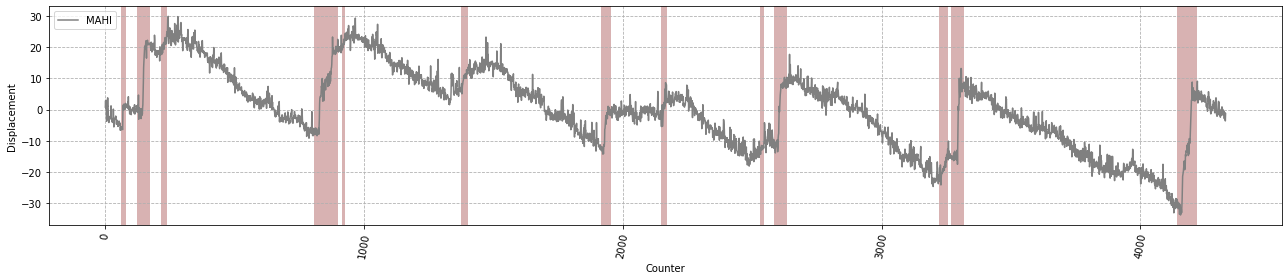

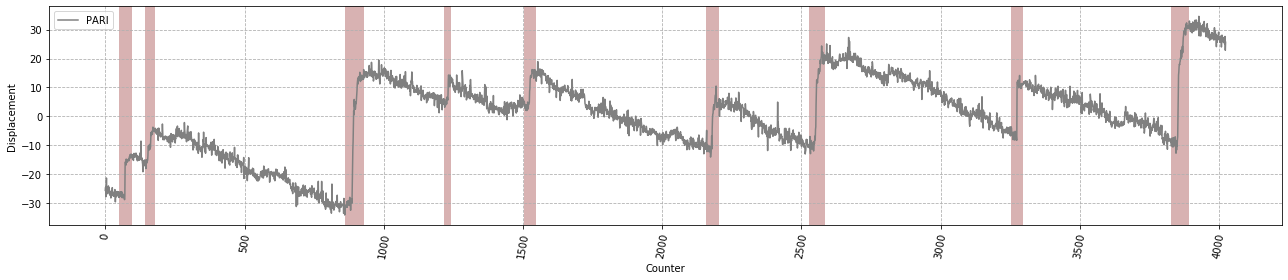

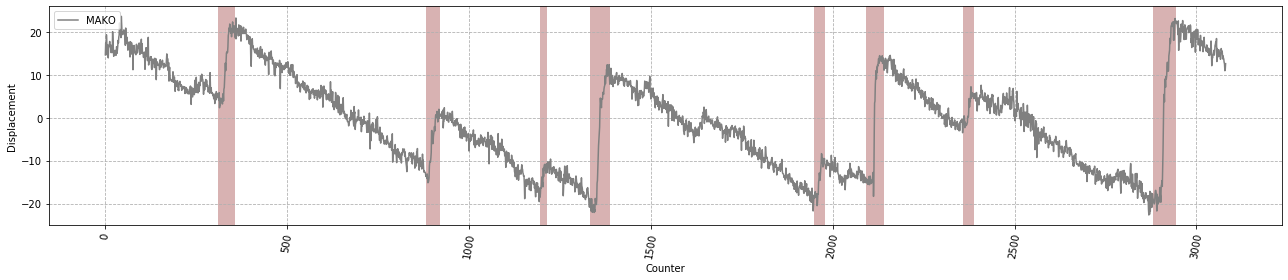

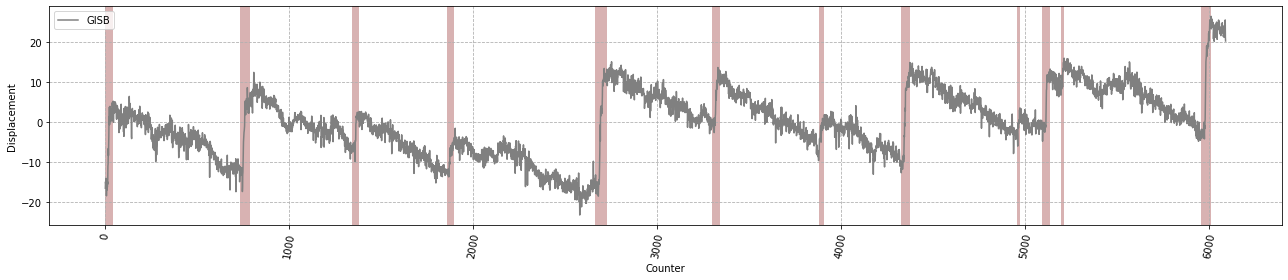

In [169]:
for i in stations_list:

    fig, ax = plt.subplots()

    plt.plot(globals()['df_{0}'.format(i)]['x'],'-', color='gray',label=i)
    plt.legend(loc=2)
    plt.xticks( rotation= 80 )

        # Grids
    plt.gca().xaxis.grid(True, linestyle='--')
    plt.gca().yaxis.grid(True, linestyle='--')

    plt.xlabel('Counter')
    plt.ylabel('Displacement')
    # if (dataset_test['Events'] == 0.5): plt.axhline()

        # Get current size
    fig_size = plt.rcParams["figure.figsize"]

        # Set figure width to 18 and height to 4
    fig_size[0] = 18
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size



    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    theta = 0.5
    ax.fill_between(range(len(globals()['df_{0}'.format(i)]['Events'])), 
                    min(globals()['df_{0}'.format(i)]['Events']), 
                    max(globals()['df_{0}'.format(i)]['Events']), 
                    where=(globals()['df_{0}'.format(i)]['Events'] > 0.5), 
                    facecolor='maroon',
                    alpha=0.3, transform=trans) 

    # plt.show()

    plt.tight_layout()
    plt.plot()

In [31]:
input_X_MAHI = df_MAHI.loc[:, df_MAHI.columns != 'Events'].values  # converts the df to a numpy array
input_X_PARI = df_PARI.loc[:, df_PARI.columns != 'Events'].values
input_X_MAKO = df_MAKO.loc[:, df_MAKO.columns != 'Events'].values
input_X_GISB = df_GISB.loc[:, df_GISB.columns != 'Events'].values




input_y_MAHI = df_MAHI['Events'].values
input_y_PARI = df_PARI['Events'].values
input_y_MAKO = df_MAKO['Events'].values
input_y_GISB = df_GISB['Events'].values

n_features_MAHI = input_X_MAHI.shape[1]  # number of features

print(input_X_MAHI.shape,input_y_MAHI.shape)

(4330, 3) (4330,)


In [8]:
def temporalize(X, y, lookback, input_X, input_y):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return np.array(X), np.array(y)

In [55]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

# 40 Days windows shifted - Standarize

In [66]:
# Temporalize the data

# lookback = 20
# X_1_MAHI, y_mahi = temporalize(X = input_X_MAHI, y = input_y_MAHI, lookback = lookback,input_X = input_X_MAHI,input_y = input_y_MAHI)

# X_mahi = X_1_MAHI.reshape(X_1_MAHI.shape[0], lookback, n_features_MAHI)

lookback = 20
X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)

In [67]:
print(X_mahi.shape,y_mahi.shape)

(4309, 20, 3) (4309,)


In [68]:
# load model
model = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days-shifted-standarize.h5")
# summarize model.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [69]:
y_pred = model.predict(X_pari)

In [70]:
df_xarray = df_PARI['x'].iloc[20:]


In [71]:
df_result = pd.DataFrame(data=[df_xarray.values,y_pred]).T
df_result.columns = ['x','Events']

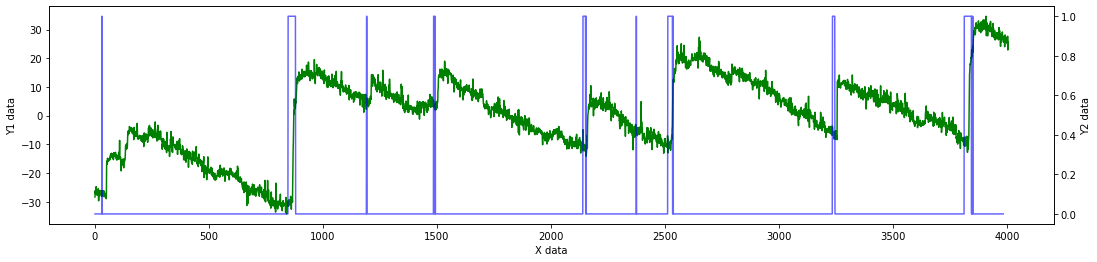

In [145]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], 'g-')
ax2.plot( df_result['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.show()

# Autoencoder Test

Best performance Autoencoder 40 days window - standarize- 128 layer


In [78]:
lookback = 40
X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)

In [79]:
# load model
model = load_model("/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder-classifier_LSTM_SSE_40window-stand.h5")
# summarize model.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 40, 128)           67584     
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 40, 64)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 40, 64)            33024     
_________________________________________________________________
lstm_28 (LSTM)               (None, 40, 128)           98816     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 40, 3)             387       
Total params: 249,219
Trainable params: 249,219
Non-trainable params: 0
________________________________________________

In [82]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_pari))

In [83]:
# Standarize the input
X_pari_scaled = scale(X_pari, scaler)


In [84]:
test_x_predictions = model.predict(X_pari_scaled)

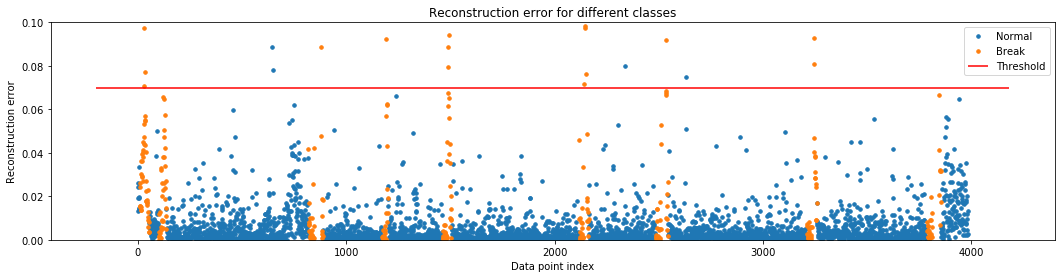

In [155]:
mse = np.mean(np.power(flatten(X_pari_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_pari.tolist()})

threshold_fixed = 0.07 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot( group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.ylim(0,0.1)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [156]:
pred_y = [1. if e > threshold_fixed else 0. for e in error_df.Reconstruction_error.values]

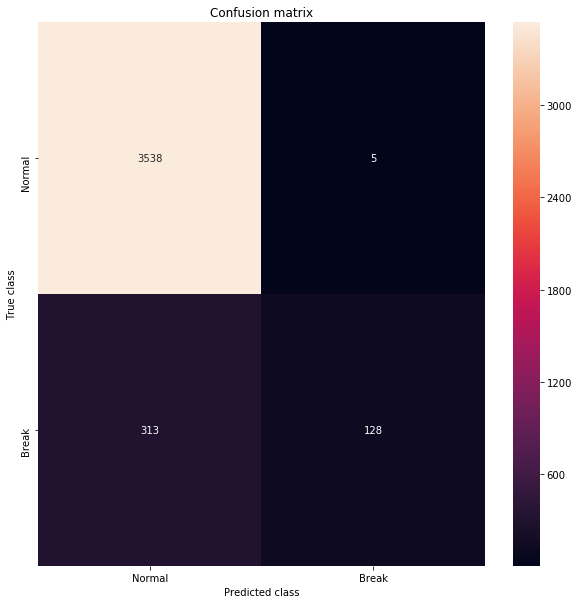

In [157]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()

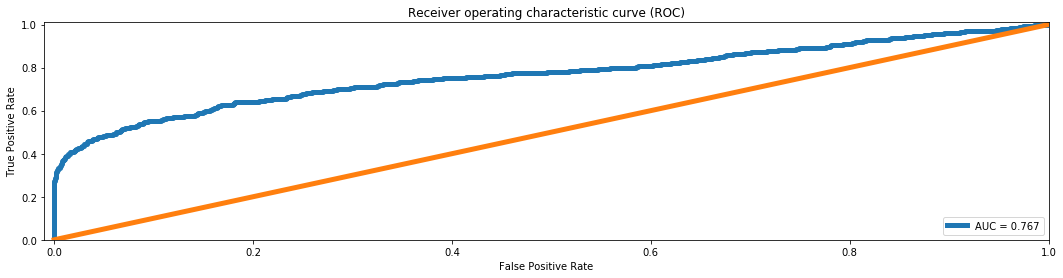

In [158]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [129]:
df_xarray = df_PARI['x'].iloc[20:]


In [130]:
df_result = pd.DataFrame(data=[df_xarray.values,pred_y]).T
df_result.columns = ['x','Events']

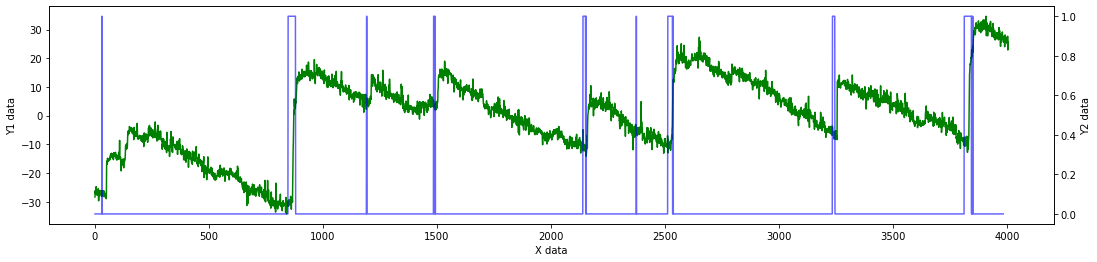

In [148]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], 'g-')
ax2.plot( df_result['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

In [124]:
# evaluate the model
scores = model.evaluate(X_pari,X_pari)
print((scores[1]*100))

3984/3984 [==============================] - 11s 3ms/step
94.64921951293945



# THe best of the Vanilla Model

40- days 


In [132]:
# load model
model_40# evaluate the model
scores = model.evaluate(X_pari,X_pari)
print((scores[1]*100)) = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days.h5")
# summarize model.
model_40.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [133]:
lookback = 40
X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)

In [140]:
y_pred_40 = model_40.predict_classes(X_pari)

y_pred_40_prob = model_40.predict(X_pari)

In [137]:
# evaluate the model
scores = model_40.evaluate(X_pari,y_pari)
print((scores[1]*100))

3984/3984 [==============================] - 5s 1ms/step
93.47389340400696


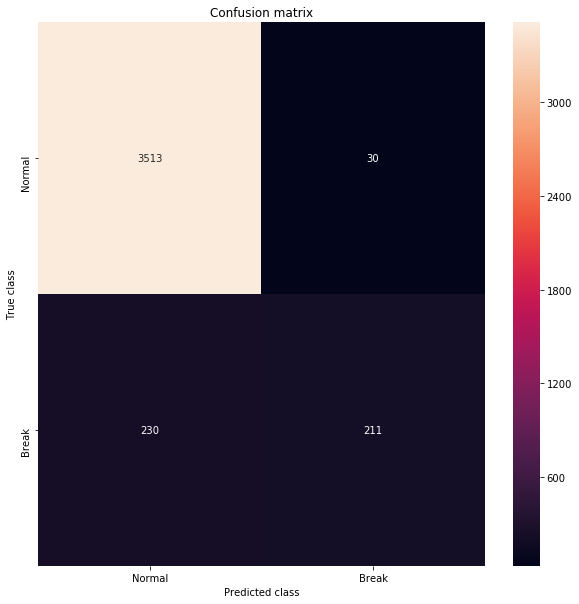

In [149]:
conf_matrix = confusion_matrix(y_pari, y_pred_40)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()

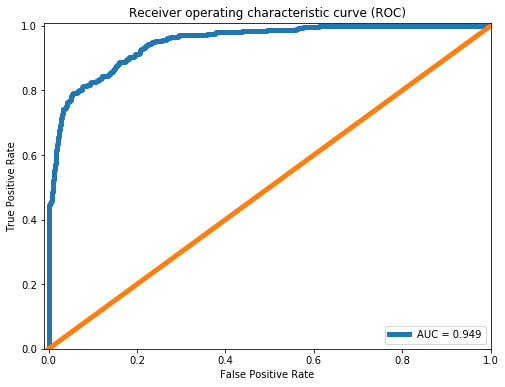

In [141]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_pari, y_pred_40_prob)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [142]:
df_xarray_40 = df_PARI['x'].iloc[40:]
df_result_40 = pd.DataFrame(data=[df_xarray_40.values,y_pred_40]).T
df_result_40.columns = ['x','Events']

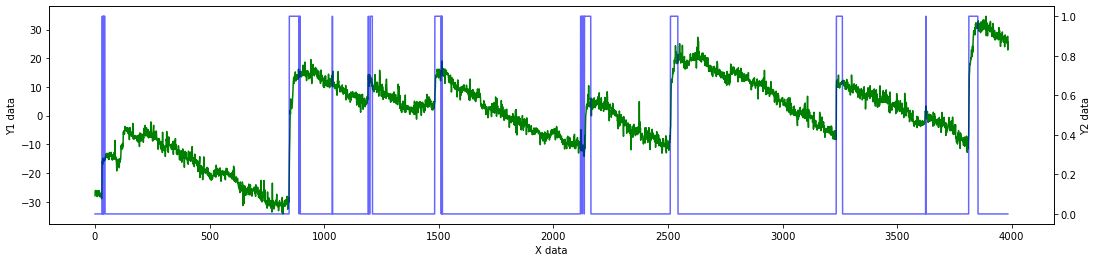

In [150]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40['x'], 'g-')
ax2.plot( df_result_40['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 40 days Window Time

In [276]:
# Temporalize the data
lookback = 40
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [277]:
# load model
model_40 = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days.h5")
# summarize model.
model_40.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [278]:
y_pred_40 = model_40.predict_classes(X_gisb)

In [279]:
df_xarray_40 = df['x'].iloc[40:]
df_result_40 = pd.DataFrame(data=[df_xarray_40.values,y_pred_40]).T
df_result_40.columns = ['x','Events']

[]

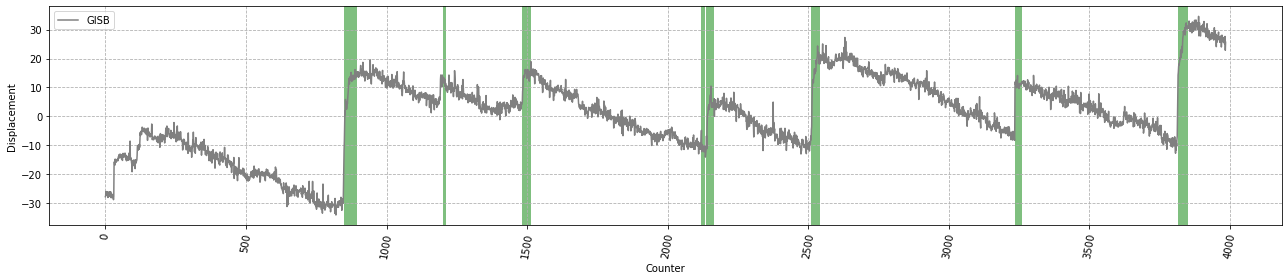

In [280]:
fig, ax = plt.subplots()

plt.plot(df_result_40['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_40['Events'])), min(df_result_40['Events']), max(df_result_40['Events']), 
                where=(df_result_40['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

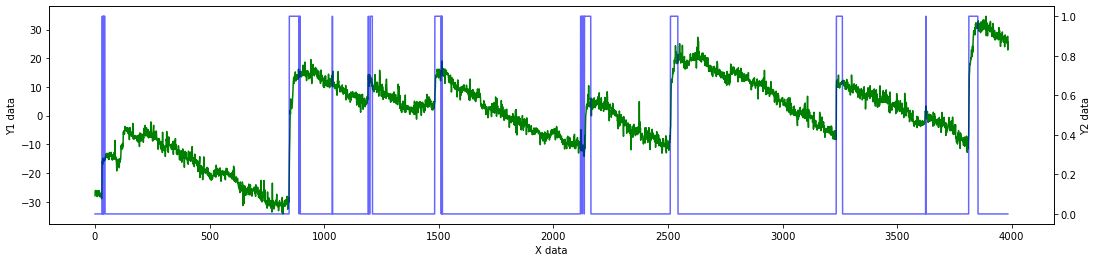

In [281]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40['x'], 'g-')
ax2.plot( df_result_40['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 5 days Window Time

In [282]:
# Temporalize the data
lookback = 5
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [283]:
# load model
model_5 = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_5days.h5")
# summarize model.
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [284]:
y_pred_5 = model_5.predict_classes(X_gisb)

In [285]:
df_xarray_5 = df['x'].iloc[5:]
df_result_5 = pd.DataFrame(data=[df_xarray_5.values,y_pred_5]).T
df_result_5.columns = ['x','Events']

[]

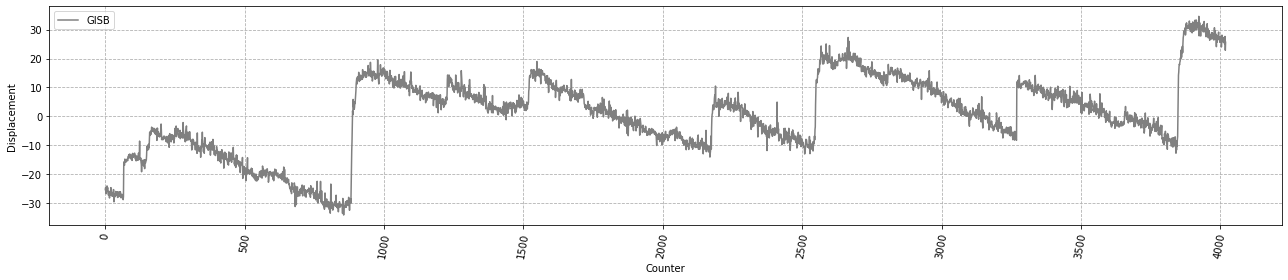

In [286]:
fig, ax = plt.subplots()

plt.plot(df_result_5['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_5['Events'])), min(df_result_5['Events']), max(df_result_5['Events']), 
                where=(df_result_5['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

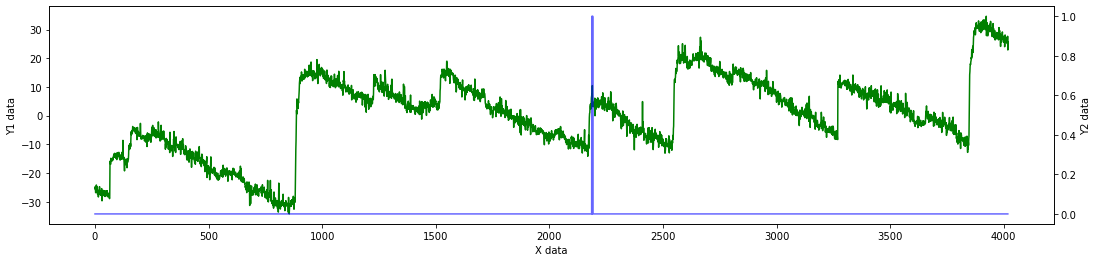

In [287]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_5['x'], 'g-')
ax2.plot( df_result_5['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 60 days Time Window

In [288]:
# Temporalize the data
lookback = 60
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [289]:
# load model
model_60 = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_60days.h5")
# summarize model.
model_60.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [290]:
y_pred_60 = model_60.predict_classes(X_gisb)

In [291]:
df_xarray_60 = df['x'].iloc[60:]
df_result_60 = pd.DataFrame(data=[df_xarray_60.values,y_pred_60]).T
df_result_60.columns = ['x','Events']

[]

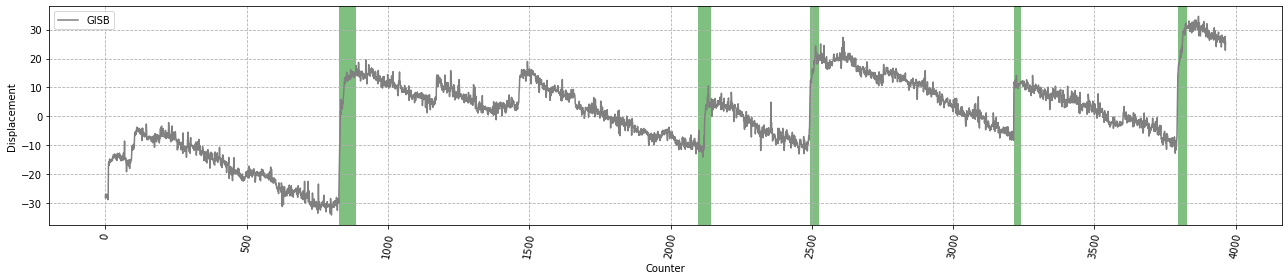

In [292]:
fig, ax = plt.subplots()

plt.plot(df_result_60['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_60['Events'])), min(df_result_60['Events']), max(df_result_60['Events']), 
                where=(df_result_60['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

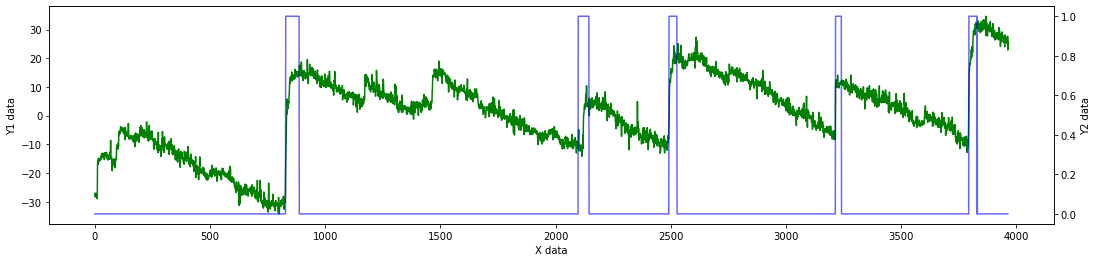

In [293]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_60['x'], 'g-')
ax2.plot( df_result_60['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 20 Days time window - Standarization

In [294]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [295]:
# load model
model_stand = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_20days_standarize.h5")
# summarize model.
model_stand.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [296]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [297]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_gisb))

In [298]:
# Standarize the input

X_gisb_scaled = scale(X_gisb, scaler)


In [299]:
a = flatten(X_gisb_scaled)
print('colwise mean', np.mean(a,axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0. -0.]
colwise variance [1. 1. 1.]


In [300]:
y_pred_stand = model_stand.predict_classes(X_gisb_scaled)

In [301]:
df_xarray_stand = df['x'].iloc[20:]
df_result_stand = pd.DataFrame(data=[df_xarray_stand.values,y_pred_stand]).T
df_result_stand.columns = ['x','Events']

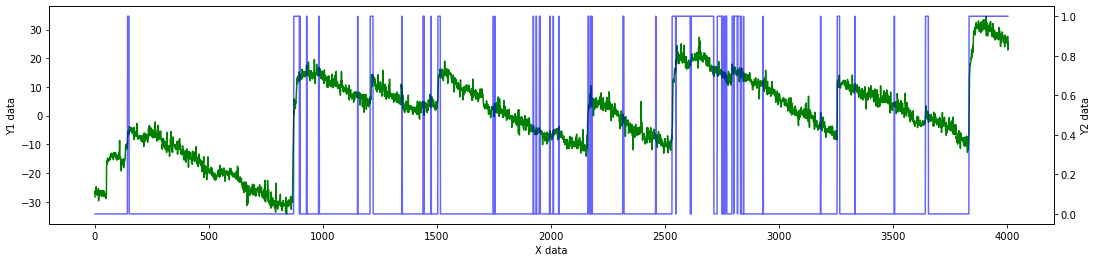

In [302]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_stand['x'], 'g-')
ax2.plot( df_result_stand['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 20 Days window time -  pre-SSE mapping

In [303]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [304]:
# load model
model_shifted = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_20days-shifted.h5")
# summarize model.
model_shifted.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [305]:
y_pred_shifted = model_shifted.predict_classes(X_gisb)

In [306]:
df_xarray_shifted = df['x'].iloc[20:]
df_result_shifted = pd.DataFrame(data=[df_xarray_shifted.values,y_pred_shifted]).T
df_result_shifted.columns = ['x','Events']

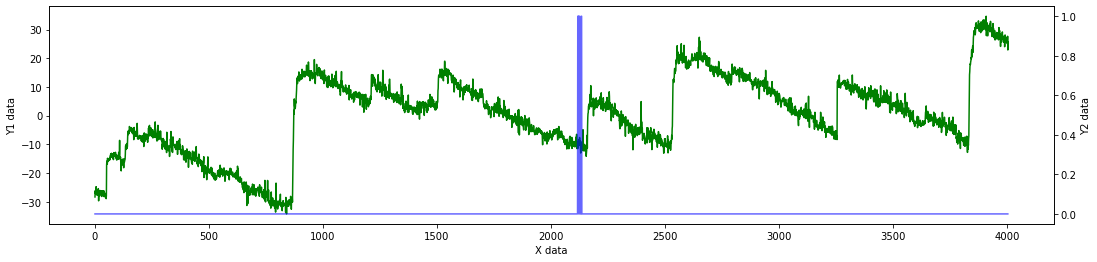

In [307]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted['x'], 'g-')
ax2.plot( df_result_shifted['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

    
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


plt.show()

In [308]:
# evaluate the model
score = model_shifted.evaluate(X_gisb,y_gisb, verbose=1)
print("%s: %.2f%%" % (model_shifted.metrics_names[1], score[1]*100))

4004/4004 [==============================] - 5s 1ms/step
acc: 88.71%


In [309]:
y_pred_shifted_prob = model_shifted.predict(X_gisb)

In [310]:
df_xarray_shifted_2 = df['x'].iloc[20:]
df_result_shifted_2 = pd.DataFrame(data=[df_xarray_shifted_2.values,y_pred_shifted_prob]).T
df_result_shifted_2.columns = ['x','Events']

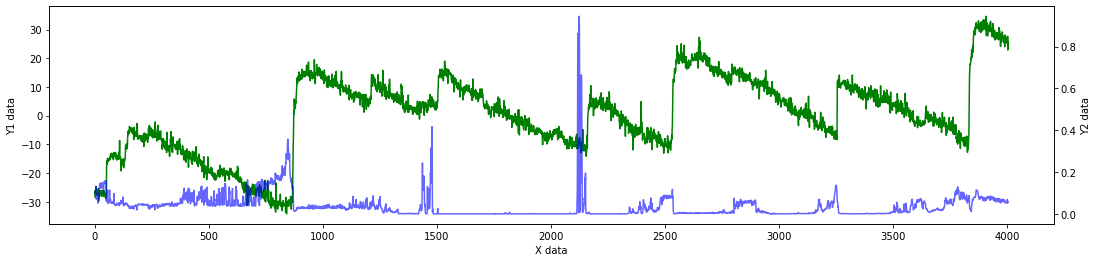

In [311]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted_2['x'], 'g-')
ax2.plot( df_result_shifted_2['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

In [312]:
# plt.plot(y)

# 40 Days window time -  pre-SSE mapping

In [327]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [328]:
# load model
model_shifted = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days-shifted.h5")
# summarize model.
model_shifted.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [329]:
y_pred_shifted = model_shifted.predict_classes(X_gisb)

In [330]:
df_xarray_shifted = df['x'].iloc[20:]
df_result_shifted = pd.DataFrame(data=[df_xarray_shifted.values,y_pred_shifted]).T
df_result_shifted.columns = ['x','Events']

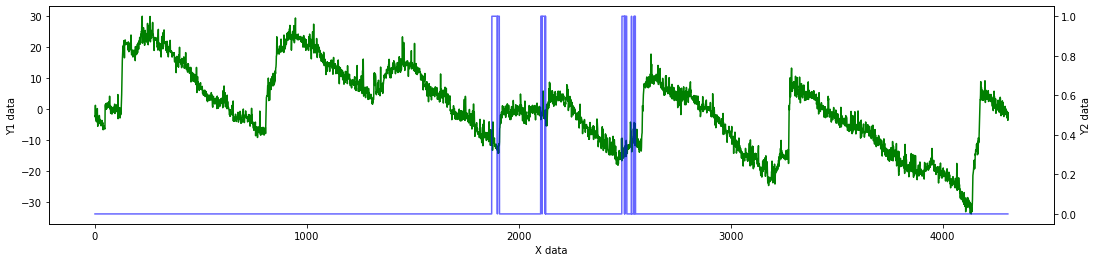

In [331]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted['x'], 'g-')
ax2.plot( df_result_shifted['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

    
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


plt.show()

In [332]:
# evaluate the model
score = model_shifted.evaluate(X_gisb,y_gisb, verbose=1)
print("%s: %.2f%%" % (model_shifted.metrics_names[1], score[1]*100))

4309/4309 [==============================] - 5s 1ms/step
acc: 86.49%


In [333]:
y_pred_shifted_prob = model_shifted.predict(X_gisb)

In [334]:
df_xarray_shifted_2 = df['x'].iloc[20:]
df_result_shifted_2 = pd.DataFrame(data=[df_xarray_shifted_2.values,y_pred_shifted_prob]).T
df_result_shifted_2.columns = ['x','Events']

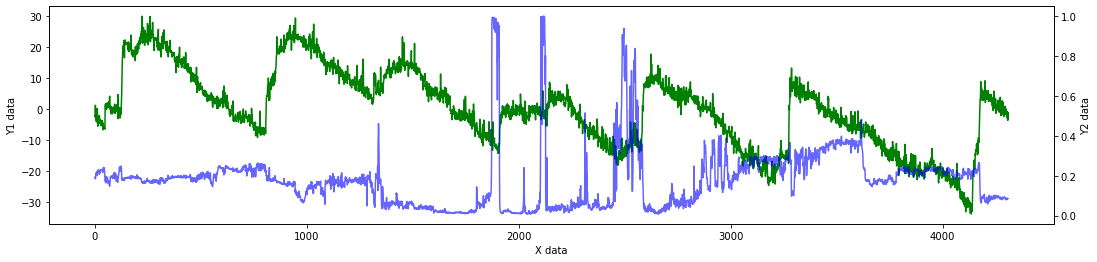

In [357]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted_2['x'], 'g-')
ax2.plot( np.sqrt(y_pred_shifted_prob), 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()